In [1]:
# Parameters
cpu = 8
group_name = "DG_Glut"
mem_gb = 10


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
import cooler
import subprocess
import glob
import pathlib
from tqdm import tqdm
from collections import defaultdict

In [3]:
#group_name = 'DG_Glut'

In [4]:
home_dir = '/home/qzeng_salk_edu/project/241018_pre_ml/'
ct = group_name


In [5]:
gene_meta = pd.read_csv('/data/ref/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t')
use_gene_types = ['protein_coding','lncRNA']

use_genes = pd.read_csv(f'{home_dir}/mm10_gene_2kb.bed', index_col = None, header = None, sep = '\t')
use_genes = use_genes[5].values

In [6]:
import pathlib
# make a dir ml_input/{ct}
pathlib.Path(f'{home_dir}/ml_input/{ct}').mkdir(parents=True, exist_ok=True)

In [7]:
# my deg analysis
pvalue_cut = 1e-5
log2fc_cut = 0.3


expr = pd.read_hdf(f'/data/female-amb/Diff.Result/DEG.stats/{ct}/expr.hdf').T
expr = expr + 1e-5
all_genes = pd.read_hdf(f'/data/female-amb/Diff.Result/DEG.stats/{ct}/deg_stats.hdf')
all_genes['log2(old/young)'] = np.log2(expr[f"{ct}.18mo"]/expr[f"{ct}.2mo"])

# highly expressed genes
highly_expressed_genes = expr.sum(axis = 1)[expr.sum(axis = 1) > 1e-3].index
all_genes = all_genes.loc[all_genes.index.isin(highly_expressed_genes)]

# add a column in all_genes, if the gene not in deg_df the value = 0; if the value in deg_df['avg_log2FC'] > 0, the value = -1; if the value in deg_df['avg_log2FC'] < 0, the value = 1
deg_df = all_genes[(all_genes['fdr'] < pvalue_cut) & (np.abs(all_genes['log2(old/young)']) > log2fc_cut)]
all_genes['DEG'] = 0
all_genes.loc[deg_df.index, 'DEG'] = all_genes.loc[deg_df.index, 'log2(old/young)'].apply(lambda x: 1 if x > 0 else -1)
all_genes = all_genes[all_genes.index.isin(use_genes)]

min_value = all_genes[all_genes['fdr'] != 0].sort_values('fdr').iloc[0]['fdr']
all_genes['-log10(fdr)'] = -np.log10(all_genes['fdr'] + min_value)
all_genes

,stats,fdr,log2(old/young),DEG,-log10(fdr)
gene,,,,,
Xkr4,323.576557,2.691351e-69,-0.187008,0,68.570030
Gm1992,312.377331,6.712878e-67,-1.829304,-1,66.173091
Mrpl15,29.183867,1.154416e-06,0.040531,0,5.937638
Lypla1,6.037245,6.604203e-02,0.183398,0,1.180180
Tcea1,30.854576,5.174600e-07,0.107180,0,6.286123
...,...,...,...,...,...
Nhlh1,1.056245,6.284981e-01,0.170464,0,0.201696
Gm5678,2.428680,3.419347e-01,1.672156,0,0.466057
Pla2g2f,3.138304,2.483605e-01,0.532965,0,0.604917


In [8]:
all_genes = all_genes[all_genes.index.isin(use_genes)]
all_genes['DEG'].value_counts()

DEG
 0    12750
-1     2285
 1      311
Name: count, dtype: int64

In [9]:
all_genes.to_csv(f"{home_dir}/ml_input/{ct}/{ct}.RNA_DEG.csv")

## luida deg

In [10]:
pvalue_cut = 1e-2
log2fc_cut = 0.3

#luisa deg analysis
deg_dir = '/data/female-amb/Diff.Result/luisa_deg'
# load luisa results
df= pd.read_csv(f'{deg_dir}/{ct}.csv', index_col=0)
#select the DEGs bt the cutoffs
deg_df = df[(df['p_val_adj'] < pvalue_cut) & (np.abs(df['avg_log2FC']) > log2fc_cut)]
deg_df.head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
Nrg1,0.0,-1.279634,0.512,0.836,0.0
Snhg11,0.0,-1.234044,0.407,0.702,0.0
Gm48530,0.0,-2.092791,0.112,0.401,0.0
Zfp804b,0.0,-1.415103,0.266,0.536,0.0
Xist,0.0,-0.855881,0.562,0.827,0.0


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


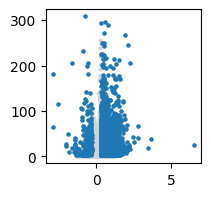

In [11]:
# plot the volcano plot, with df in the background  and DEGs in the foreground
fig, ax = plt.subplots(figsize=(2,2))
ax.scatter(df['avg_log2FC'], -np.log10(df['p_val_adj']), s=3, color='lightgray')
ax.scatter(deg_df['avg_log2FC'], -np.log10(deg_df['p_val_adj']), s=5)

In [12]:
df['DEG'] = 0
df.loc[deg_df.index, 'DEG'] = df.loc[deg_df.index, 'avg_log2FC'].apply(lambda x: -1 if x > 0 else 1)

In [13]:
df = df.loc[df.index.isin(use_genes)]

In [14]:
df.sort_values('p_val_adj').head(20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,DEG
Nrg1,0.000000e+00,-1.279634,0.512,0.836,0.000000e+00,1
Snhg11,0.000000e+00,-1.234044,0.407,0.702,0.000000e+00,1
Zfp804b,0.000000e+00,-1.415103,0.266,0.536,0.000000e+00,1
Xist,0.000000e+00,-0.855881,0.562,0.827,0.000000e+00,1
Nrxn3,0.000000e+00,-1.176254,0.774,0.985,0.000000e+00,1
Camk2d,0.000000e+00,-3.280839,0.032,0.242,0.000000e+00,1
Meg3,0.000000e+00,-1.000236,0.900,0.973,0.000000e+00,1
Rfx3,0.000000e+00,0.488790,0.992,0.953,0.000000e+00,-1
Grin2a,0.000000e+00,0.470946,0.999,0.993,0.000000e+00,-1
Zbtb20,0.000000e+00,0.390037,1.000,0.998,0.000000e+00,-1


In [15]:
df['DEG'].value_counts()

DEG
 0    5461
-1    2659
 1     190
Name: count, dtype: int64

In [16]:
# save the table out as f"{ct}.RNAseq_DEG.hdf"
df.to_csv(f"{home_dir}/ml_input/{ct}/{ct}.luisa_RNA_DEG.csv")

## gene meta

In [17]:
# gene_meta = pd.read_csv('/data/ref/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t')
# gene_meta = gene_meta[['chrom','start','end','gene_id','strand','gene_name','gene_type']]
# # slop start and end 2000
# gene_meta['start'] = gene_meta['start'] - 2000
# gene_meta['end'] = gene_meta['end'] + 2000
# # remove chrM, chrX and chrY
# gene_meta = gene_meta[~gene_meta['chrom'].isin(['chrM','chrX','chrY'])]
# gene_meta

In [18]:
# gene_meta.to_csv('mm10_gene_2kb.bed', sep = '\t', index = False, header = False)